# 量子回路における加算器（2020年 Week1a）

## はじめに
### 目的
本演習では、量子回路を用いて、古典論理回路による加算器と論理的に等価な回路を作成することを目的とします。  
本演習を行うにあたり、必要となる前提知識は以下の通りです。可能な限り下記項目の概要を調べ、理解しておくことを推奨します。  

演習ではまず最初に量子回路を使った様々な論理ゲート（AND, OR, XORなど）と、ブロッホ球表示について扱います。
その後、古典の加算器と等価な計算を量子回路で実現する方法を演習を通して学ぶことができます。下記の通り、演習を通して量子計算手法の基礎を身に着けることができます。

### 前提知識
1. 古典論理回路と真理値表
1. 半加算器・全加算器

### 演習で身につく知識
1. 量子回路の基礎
1. ブロッホ球表示
1. Unrollerによる量子回路の分解・量子コスト計算
1. 量子回路を用いた半加算器・全加算器の実装

### 準備：演習で使用するモジュールのインポート

In [1]:
# 標準のQiskitライブラリーをインポートしてアカウントを構成する
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
from qiskit.visualization import plot_bloch_multivector

## 量子回路の基礎

ブロッホ球とは？
> ブロッホ球とは、量子ビットの状態を単位球面上に表す表記法です。量子ビットの任意の純粋状態 $\ket \psi$ は $\ket 0$ と $\ket 0$ の重ね合わせで表現できるため、ブロッホ球上の極座標として表現することができます。  
（簡単に数式で説明すると、、、）  
$\ket 0$と $\ket 0$ の重ね合わせ状態を式で表すと、このようになります。$$ \ket \psi = \alpha \ket 0 + \beta \ket 1$$
> 重ね合わせ状態のうち、$\alpha$ は $\ket 0$ の占める割合、$\beta$ は $\ket 0$ の占める割合であり（確率振幅）、以下の式が成り立ちます。$$ |\alpha|^2 + |\beta|^2 = 1 $$
>例えば、単純な量子ビット $ \ket 0 $と、重ね合わせ状態 $ (1 / \sqrt 2)(\ket 0 + \ket 1)$ をブロッホ球で表現すると以下のように表されます。

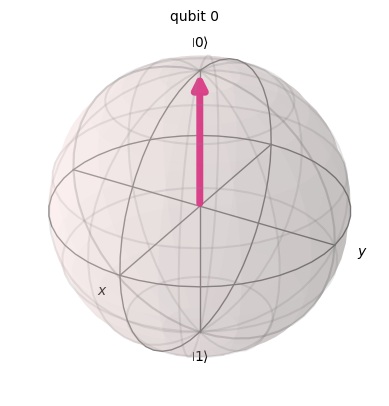

In [2]:
# 単純な量子ビット|0>のブロッホ球表示
q = QuantumRegister(1)
qc = QuantumCircuit(q)

backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result().get_statevector(qc, decimals=3)
plot_bloch_multivector(result)


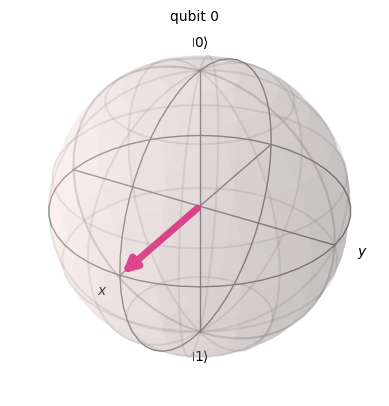

In [3]:
# 重ね合わせ状態 1/√2 (|0> + |1>)
q = QuantumRegister(1)
qc = QuantumCircuit(q)
qc.h(q[0])

backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result().get_statevector(qc, decimals=3)
plot_bloch_multivector(result)

量子回路とは？
> 量子回路は、量子計算の過程を記述する手法の１つで、基本的な操作を行う量子ゲートを組み合わせて構成されます。本章ではまず、いくつかの主要な量子ゲートをご紹介します。  
以下より、さっそく基本的な単一量子ゲートを動かしてみましょう

### Xゲート
Xゲートはブロッホ球の$x$軸周りの$\pi$回転です。
すなわち、 $\ket 0$ にXゲートを適用すると $\ket 1$ 、 $\ket 1$ にXゲートを適用すると $\ket 0$ になるので、古典のNOTゲートのような操作が実現でき、ビット反転とも呼ばれます。<br/>線形代数について学習したい方はQiskit Textbookのこちらの章をご覧ください：[Linear Algebra](https://github.com/qiskit-community/qiskit-textbook/blob/master-ja/content/ch-appendix/linear_algebra.ipynb)

xゲートを代数的に表現すると下記のように表されます。

$X = \begin{pmatrix}
0 & 1 \\
1 & 0 \\
\end{pmatrix}$

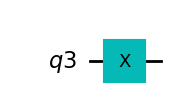

In [4]:
# |0> qubitにXゲートをかけてみましょう
q = QuantumRegister(1)
qc = QuantumCircuit(q)
qc.x(q[0])
qc.draw(output='mpl')

注：新表記では`QuantumRegister`を省略するコーディング方法もありますが、今回のChallengeでは、こちらのコーディング法を使います。複雑な量子回路のアルゴリズムを理解しやすくするためです。（新表記についてはこちらをご覧ください：https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html?highlight=quantumcircuit#qiskit.circuit.QuantumCircuit）

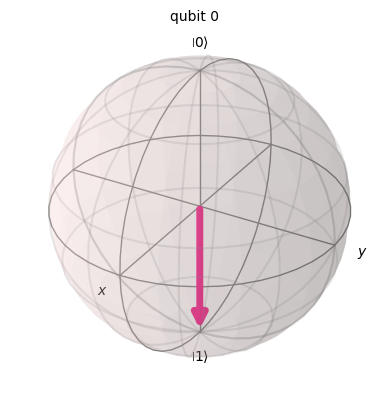

In [5]:
# ブロッホ球表示で結果を見てみましょう
## 初期状態|0>がビット反転して、|1>となっていれば成功です！
backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result().get_statevector(qc, decimals=3)
plot_bloch_multivector(result)

### Hゲート
Hadamardゲート(アダマールゲート)はブロッホ球の$x$軸と$z$軸の中間の軸周りの$\pi$回転です。
例えば$|0\rangle$にHゲートを適用すると、$\frac{|0\rangle + |1\rangle}{\sqrt{2}}$のような重ね合わせ状態（測定すると0または1になる確率が等しい状態）を作ることができます。この状態は$|+\rangle$とも表記されます。

Hゲートを代数的に表現すると以下のように表されます。

$H = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1 \\
1 & -1 \\
\end{pmatrix}$

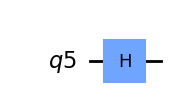

In [6]:
# |0> qubitにHゲートをかけてみましょう
q = QuantumRegister(1)
qc = QuantumCircuit(q)
qc.h(q[0])
qc.draw(output='mpl')

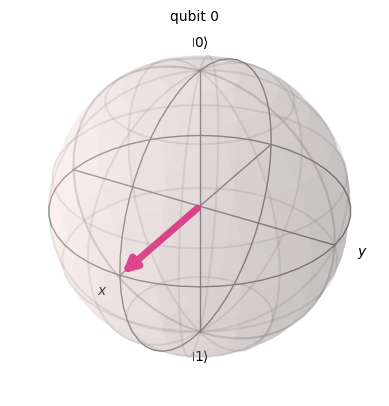

In [7]:
# ブロッホ球表示で結果を見てみましょう
## |0>と|1>の存在確率が等しくなっているでしょうか？
backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result().get_statevector(qc, decimals=3)
plot_bloch_multivector(result)

### Zゲート
Zゲートはブロッホ球の$z$軸周りの$\pi$回転です。位相反転とも呼ばれます。  
（重ね合わせ状態は確率振幅の他に、位相を持ちます。ここではブロッホ球の緯線の方向が反転するという理解で十分です）

Zゲートを代数的に表現すると下記のように表されます。

$Z = \begin{pmatrix}
1 & 0 \\
0 & -1 \\
\end{pmatrix}$

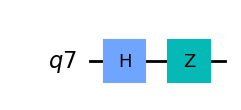

In [8]:
# |+>にZゲートをかけてみましょう
q = QuantumRegister(1)
qc = QuantumCircuit(q)
qc.h(q[0])
qc.z(q[0])
qc.draw(output='mpl')

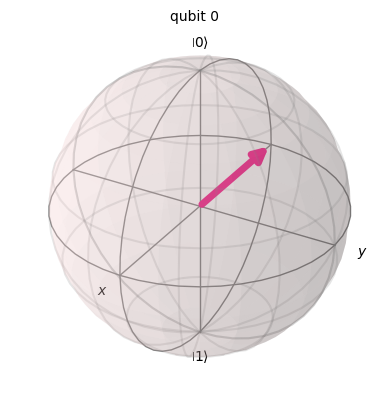

In [9]:
# 結果を見てみましょう
## 先ほどのHゲートの結果と位相反転していれば成功です！
backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result().get_statevector(qc, decimals=3)
plot_bloch_multivector(result)

> ここまでは単純な単一量子ゲートのXゲート、Hゲート、Zゲートを扱いました。  
ここからは、複数の量子ビットを入出力に持つ、CXゲート、CZゲート、CCXゲートについて扱います

### CXゲート(CNOTゲート)
CXゲート（Control-Xゲート）は制御NOTゲート、CNOTとも呼ばれます。CXゲートは、２つの量子ビット(制御量子ビットとターゲット量子ビットと呼びます)を入出力に持ち、制御量子ビットが$|1\rangle$のときに、ターゲット量子ビットに対してビット反転(Xゲート)を行います。(Qiskitでは、番号の大きい量子ビットほど高い位のビット数に対応しています。つまり、右から順に番号付けされます。)

CXゲートを代数的に表現すると下記のように表されます。

$CX = \begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0\\
\end{pmatrix}$

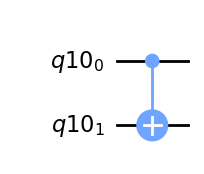

In [10]:
# |00>にCXゲートをかけてみましょう
q = QuantumRegister(2)
qc = QuantumCircuit(q)
qc.cx(q[0],q[1])
qc.draw(output='mpl')

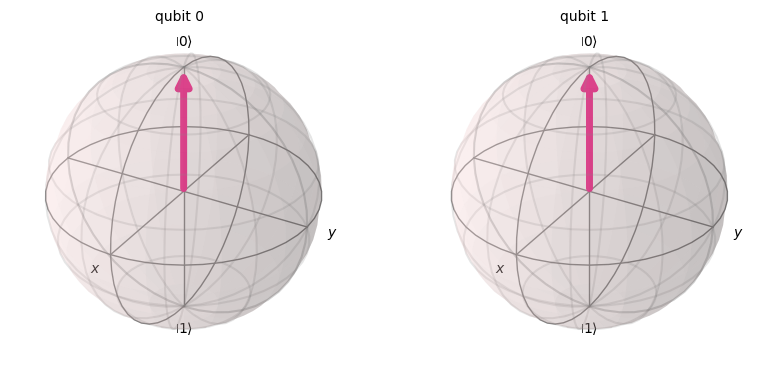

In [11]:
# 結果を見てみましょう
## 今回はq0がコントロールビット、q1がターゲットビットです。コントロールビットが|0>なので何も起きていませんね
backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result().get_statevector(qc, decimals=3)
plot_bloch_multivector(result)

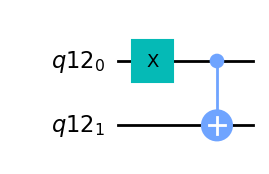

In [12]:
# コントロールビットを|1>にして|10>にCXゲートをかけてみましょう
q = QuantumRegister(2)
qc = QuantumCircuit(q)
qc.x(q[0])
qc.cx(q[0], q[1])
qc.draw(output='mpl')

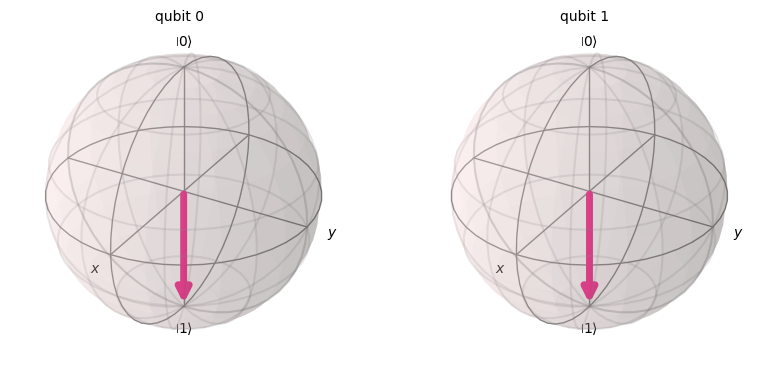

In [13]:
# 結果を見てみましょう
## |11>となっていれば成功です！
backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result().get_statevector(qc, decimals=3)
plot_bloch_multivector(result)

### CZゲート
CZゲートも、２つの量子ビット(制御量子ビットとターゲット量子ビットと呼びます)を入出力に持ち、制御量子ビットが$|1\rangle$のときに、ターゲット量子ビットに対して位相反転(Zゲート)を行います。

CZゲートを代数的に表現すると下記のように表されます。

$CZ = \begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & -1\\
\end{pmatrix}$

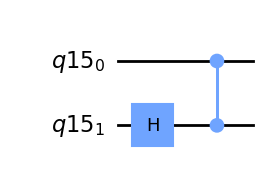

In [14]:
# |0+>状態を作ってから、CZゲートをかけてみましょう
## コントロールビットq0の状態が|0>なので、ターゲットビットq1は変わらず|+>となるはずです
q = QuantumRegister(2)
qc = QuantumCircuit(q)
qc.h(q[1])
qc.cz(q[0],q[1])
qc.draw(output='mpl')

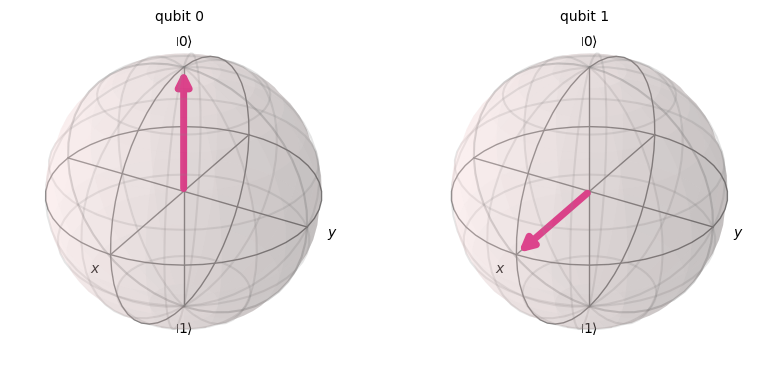

In [15]:
# 結果を見てみましょう
backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result().get_statevector(qc, decimals=3)
plot_bloch_multivector(result)

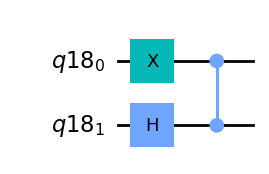

In [16]:
# |1+>状態を作ってから、CZゲートをかけてみましょう
## コントロールビットq0の状態が|1>なので、q1は|+>から|->になるはずです
q = QuantumRegister(2)
qc = QuantumCircuit(q)
qc.x(q[0])
qc.h(q[1])
qc.cz(q[0],q[1])
qc.draw(output='mpl')

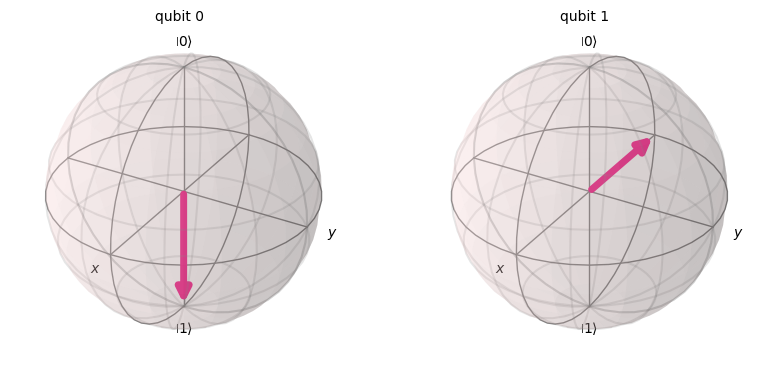

In [17]:
# 結果を見てみましょう
## ターゲットビットq1が位相反転して|->になっていれば成功です！
backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result().get_statevector(qc, decimals=3)
plot_bloch_multivector(result)

※なお、CZゲートはCXゲートとHゲートから作ることができます。

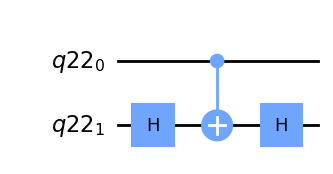

In [18]:
# CZゲートをCXゲートとHゲートから作ります
q = QuantumRegister(2)
qc = QuantumCircuit(q)

qc.h(q[1])
qc.cx(q[0],q[1])
qc.h(q[1])
qc.draw(output='mpl')

### CCXゲート
CCXゲートはToffoliゲートとも呼ばれます。

CCXゲートは、3つの量子ビット(2つの制御量子ビットと1つのターゲット量子ビット)を入出力に持ち、制御量子ビットが2つとも$|1\rangle$ のときに、ターゲット量子ビットに対してビット反転(Xゲート)を行います。(Qiskitでは、右から順に番号付けされることに注意してください。)

Toffoliゲートを代数的に表現すると下記のように表されます。

$CCX = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
\end{pmatrix}$

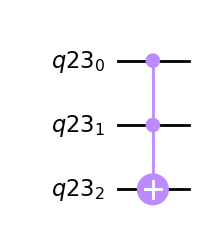

In [19]:
# |00>にCCXゲートをかけてみましょう
q = QuantumRegister(3)
qc = QuantumCircuit(q)
qc.ccx(q[0],q[1],q[2])
qc.draw(output='mpl')

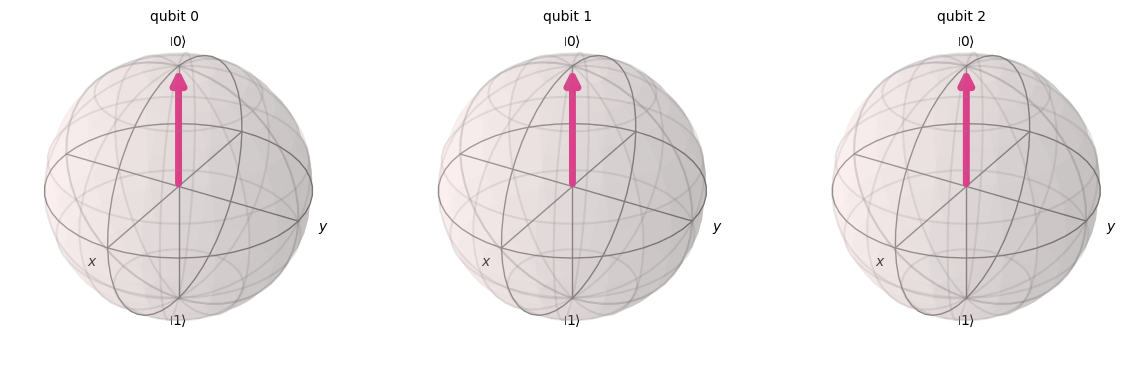

In [20]:
# 結果を見てみましょう
## 例によって何も作用しないため、|000>となっているはずです
backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result().get_statevector(qc, decimals=3)
plot_bloch_multivector(result)

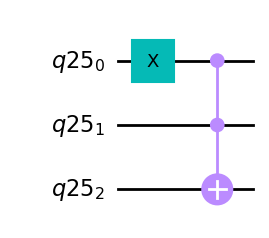

In [21]:
# |10>にCCXゲートをかけてみましょう
q = QuantumRegister(3)
qc = QuantumCircuit(q)
qc.x(q[0])
qc.ccx(q[0],q[1],q[2])
qc.draw(output='mpl')

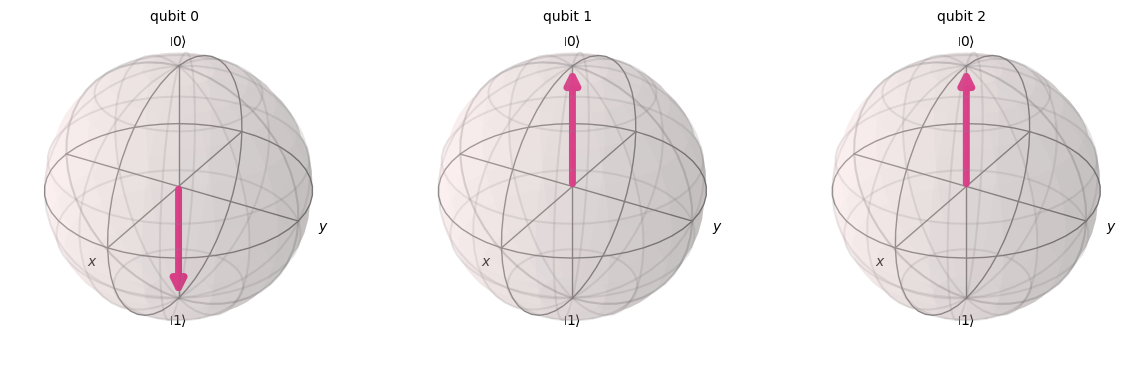

In [22]:
# 結果を見てみましょう
## Toffoliゲートでは、q0とq1の両方が|1>になっていないとq2ビットに作用しません。よって結果は|100>です
backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result().get_statevector(qc, decimals=3)
plot_bloch_multivector(result)

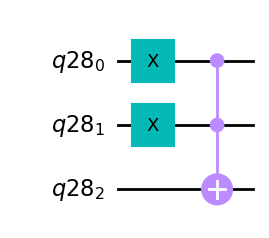

In [23]:
# 最後に|11>にCCXゲートをかけてみましょう
q = QuantumRegister(3)
qc = QuantumCircuit(q)
qc.x(q[0])
qc.x(q[1])
qc.ccx(q[0],q[1],q[2])
qc.draw(output='mpl')

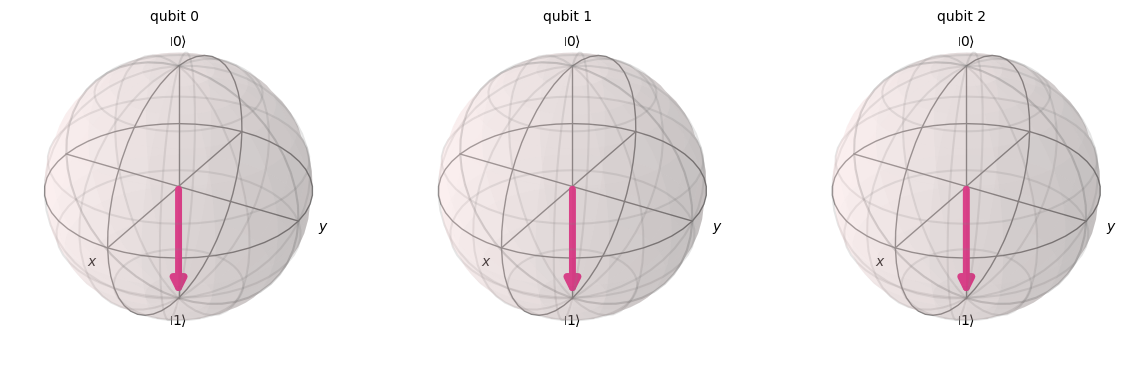

In [24]:
# 結果を見てみましょう
## q0とq1の両方が|1>であるため、ターゲットビットであるq2がビット反転して、|111>となっていれば成功です！
backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result().get_statevector(qc, decimals=3)
plot_bloch_multivector(result)

※その他の量子ゲートの詳細に関しては[Single Qubit Gates](https://qiskit.org/textbook/ch-states/single-qubit-gates.html) をご覧ください。

## 古典の論理ゲートを量子ゲートで作成する
ここまで、基本的な量子ゲートを学びました。
次は、古典の論理ゲート
1. NOTゲート
1. ANDゲート
1. NANDゲート
1. ORゲート
1. XORゲート
1. NORゲート
  
  を量子ゲートで作成してみましょう。  

この章では、真理値表と量子回路による表現を示します。なお、量子レジスタをq、古典レジスタをcとし、測定結果を作成する論理ゲートの出力とします。

### NOTゲート
先述の通り、XゲートをNOTゲートとみなすことができます。 真理値表は以下のようになります。


|入力|出力|
|--|--|
|0|1|
|1|0|

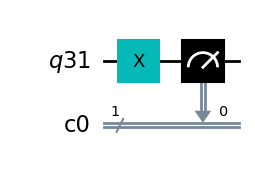

In [25]:
# 量子レジスター1個と古典レジスター1個の量子回路を作成する
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q,c)
qc.x(q[0])
qc.measure(q[0], c[0])    # 測定した結果を古典ビットにマップする
qc.draw(output='mpl')

### ANDゲート
ANDゲートの真理値表は以下のようなものです。

|入力A|入力B|出力|
|--|--|--|
|0|0|0|
|0|1|0|
|1|0|0|
|1|1|1|

CCXゲートを用いると、制御量子ビット2つに対するANDゲートの結果をターゲット量子ビットに得られます。
  
  ex. 
> q0, q1を制御量子ビットとした場合、q0とq1に対するAND演算の結果がq2に格納されます。

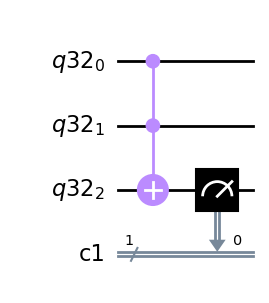

In [26]:
q = QuantumRegister(3)
c = ClassicalRegister(1)
qc = QuantumCircuit(q,c)
qc.ccx(q[0], q[1], q[2])
qc.measure(q[2], c[0])
qc.draw(output='mpl')

### NANDゲート
NANDゲートはANDゲートにNOTゲートを適用したものと捉えることができます。
よって、先ほどのANDゲートのq2ビットにNOTゲートを作用させます。

|入力A|入力B|出力|
|--|--|--|
|0|0|1|
|0|1|1|
|1|0|1|
|1|1|0|

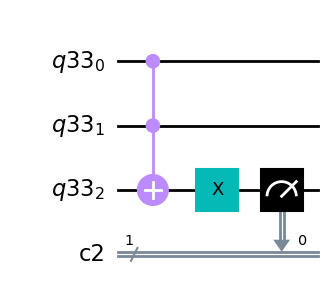

In [27]:
q = QuantumRegister(3)
c = ClassicalRegister(1)
qc = QuantumCircuit(q,c)
qc.ccx(q[0], q[1], q[2])
qc.x(q[2])
qc.measure(q[2], c[0])
qc.draw(output='mpl')

### ORゲート
ORゲートは2入力の一方が1であれば1出力が1となる、下記の論理表のような入出力を持つ論理ゲートです。  
量子回路を用いる場合、ANDゲートと同じようにq0ビット、q1ビットを2入力、q2ビットを1出力とし、CXゲートとCCXゲートを用いることでORゲートを再現することができます。

|入力A|入力B|出力|
|--|--|--|
|0|0|0|
|0|1|1|
|1|0|1|
|1|1|1|

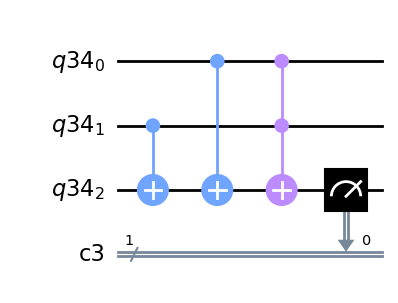

In [28]:
q = QuantumRegister(3)
c = ClassicalRegister(1)
qc = QuantumCircuit(q,c)

qc.cx(q[1], q[2])
qc.cx(q[0], q[2])
qc.ccx(q[0], q[1], q[2])
qc.measure(q[2], c[0])
qc.draw(output='mpl')

### XORゲート
XORゲートは2入力が一致しない場合に1を出力する論理ゲートです。  
量子回路を用いる場合、CXゲートを用いることでXORゲートを再現できます。

|入力A|入力B|出力|
|--|--|--|
|0|0|0|
|0|1|1|
|1|0|1|
|1|1|0|

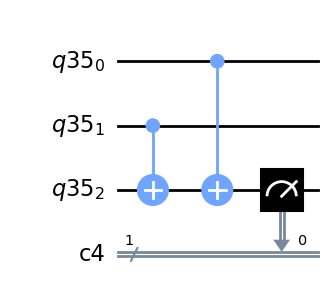

In [29]:
q = QuantumRegister(3)
c = ClassicalRegister(1)
qc = QuantumCircuit(q,c)
qc.cx(q[1], q[2])
qc.cx(q[0], q[2])
qc.measure(q[2], c[0])
qc.draw(output='mpl')

### NORゲート 
NORゲートはORゲートの出力にNOTゲートを作用させることで実現できます。

|入力A|入力B|出力|
|--|--|--|
|0|0|1|
|0|1|0|
|1|0|0|
|1|1|0|

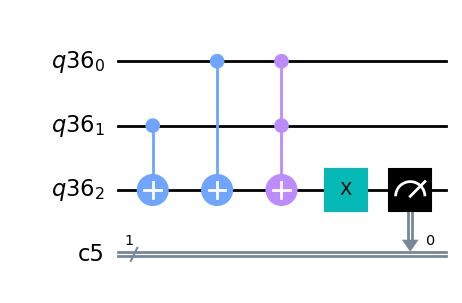

In [30]:
q = QuantumRegister(3)
c = ClassicalRegister(1)
qc = QuantumCircuit(q,c)

qc.cx(q[1], q[2])
qc.cx(q[0], q[2])
qc.ccx(q[0], q[1], q[2])
qc.x(q[2])
qc.measure(q[2], c[0])
qc.draw(output='mpl')

## 加算器
ここまでの章で、
1. 量子回路の基礎
1. 量子回路を用いた古典論理ゲートの再現
  
を学んできました。これで量子回路を用いた加算器を作ることができます。

加算器は足し算を行う論理回路です。  
今回は最もシンプルな加算器である半加算器と全加算器を用いた加算器に関して考えます。

### 半加算器
半加算器は2つのビット列の同じ桁の値同士を加算し、その桁の加算後の値と上位桁への繰り上がりの有無を表す「桁上げ出力、キャリー(Carry out)」の2つを出力するような論理回路です。桁上げ出力は、繰り上がりがあれば1、なければ0となります。  
この半加算器を用いて、後述の全加算器を作成します。

半加算器は以下の様な2入力2出力の真理値表の論理回路で表すことができます。
2入力A, Bはそれぞれ2つのビット列の同じ桁同士、出力Sはその桁の出力、桁上げ出力Cは繰り上がりの値です。

|入力A|入力B|出力S|桁上げ出力C|
|-----------|------------|------------|------------|
|0|0|0|0|
|0|1|1|0|
|1|0|1|0|
|1|1|0|1|

この真理値表を見ると、桁上げ出力Cは入力Aと入力Bに対してANDを適用したものであること、出力Sは入力Aと入力Bに対してXORを適用したものであることがわかります。
ANDとXORに関してはすでに作成済みなので、以下のように組み合わせて半加算器の量子回路が作成してみましょう。

なお、量子レジスタをq, 古典レジスタcとし、入力A, Bをq[0],q[1]に、出力S,桁上げ出力C,をq[2], q[3]に割り振ります。
また、出力結果はc[1], c[0]の順になっていることに注意して下さい。

{'00': 1000}


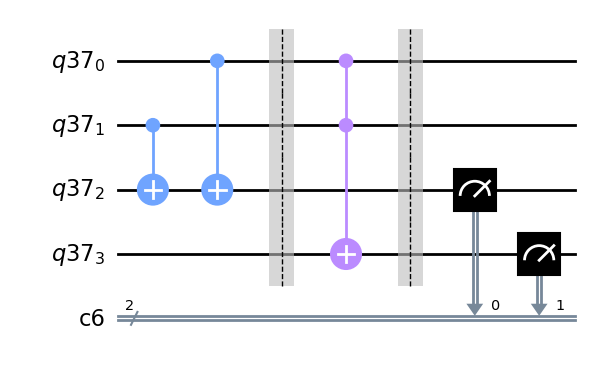

In [31]:
#各レジスター、量子回路を宣言
q = QuantumRegister(4)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)

#XOR
qc.cx(q[1], q[2])
qc.cx(q[0], q[2])
qc.barrier()

#AND
qc.ccx(q[0], q[1], q[3])
qc.barrier()

#Sum
qc.measure(q[2], c[0])
#Carry out
qc.measure(q[3], c[1])

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
result = job.result()
count =result.get_counts()
print(count)
qc.draw(output='mpl')

## 重要: Unrollerを用いた量子コストの導出
全加算器を作成する前に、量子回路の性能についてここで学んでおきましょう。
プログラム(量子回路)を評価する手法はいくつか存在します。
代表的なものとしては、

1. 量子ビット数
2. 深さ
3. 実行速度
4. 命令数

があります。  
これらはどれも量子計算の結果やスループットなどに影響する重要な尺度ですが、今回のQuantum Challengeでは特に4の命令数を指標として、以下のようにプログラムを評価します。また、この指標を今回のQuantum Challengeではコストと呼称します。

> コスト $=$ 単一量子ビットゲートの数 $+$ CXゲートの数 $\times 10$

なぜこのように単一量子ビットゲートとCXゲートによってコストを計算するのかというと、任意の量子回路は単一量子ビットゲート(1量子ビットに対する命令)と2量子ビットゲートに対する命令に分解できるためです。  
（※現在のノイズの多い中規模量子デバイス（NISQ）では、CXゲートのエラー率は一般に単一量子ビットゲートの10倍です。よって、コストでは、CXゲートの重みづけを単一量子ビットゲートの10倍としています。）

また、unrollerと呼ばれるプログラムを用いることで、皆さんのお手元でもこのコストを導出することができます。  
例えば、以下のような量子回路があったとします。

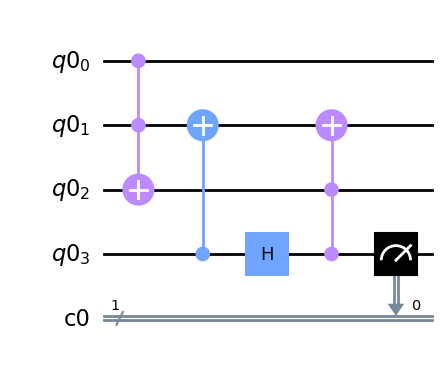

In [32]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import BasicAer, execute
from qiskit.quantum_info import Pauli, state_fidelity, process_fidelity
q = QuantumRegister(4, 'q0')
c = ClassicalRegister(1, 'c0')
qc = QuantumCircuit(q, c)
qc.ccx(q[0], q[1], q[2])
qc.cx(q[3], q[1])
qc.h(q[3])
qc.ccx(q[3], q[2], q[1])
qc.measure(q[3],c[0])
qc.draw(output='mpl')

In [33]:
# qiskitのメソッドcount_ops()でゲートの数をカウントすることができます
qc.count_ops()

OrderedDict([('ccx', 2), ('cx', 1), ('h', 1), ('measure', 1)])

この量子回路にはHゲート、CXゲート、CCXゲートが入っています。qiskit.transpilerを使ってPassManagerをインポートすることで、以下のようにUnrollerによって指定されたゲートに分解できます。この場合では、u3ゲートとcxゲートに分解します。

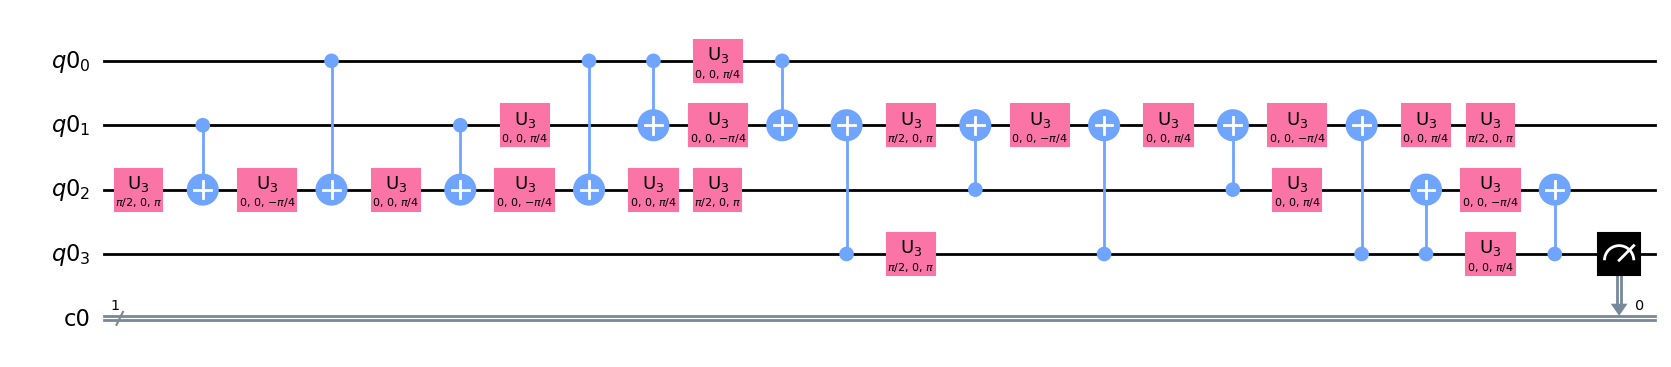

In [34]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc) 
new_circuit.draw(output='mpl')

In [35]:
new_circuit.count_ops()

OrderedDict([('u3', 19), ('cx', 13), ('measure', 1)])

よって、この回路のコストは$19+13\times10=149$ということになります。
このように、以下の手順によって量子回路の性能を評価してみましょう。
1. 任意の量子回路をUnrollerで単一量子ビットゲートとCXゲートに分割する
1. 上述のコスト計算方法によってコストを計算する

※単一量子ビットゲートやCXゲート以外のゲートが、Unrollerによってどのように分解されるかは簡単に確認できるので、興味がある人は自分で調べてみましょう。以下ではサンプルとして、CCXゲートをu3ゲートとCXゲートに分解しています。

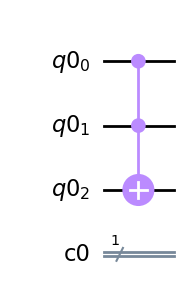

In [36]:
q = QuantumRegister(3, 'q0')
c = ClassicalRegister(1, 'c0')
qc = QuantumCircuit(q, c)
qc.ccx(q[0], q[1], q[2])
qc.draw(output='mpl')

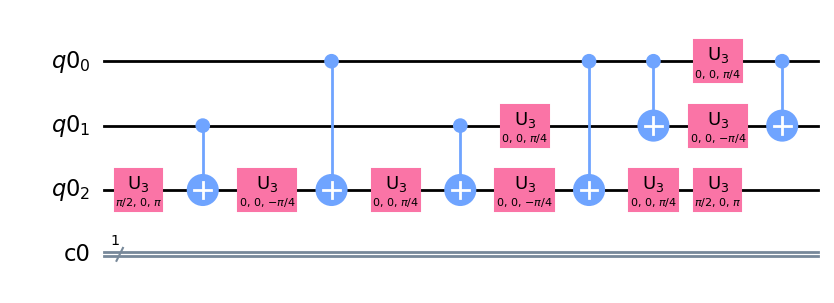

In [37]:
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc) 
new_circuit.draw(output='mpl')

In [38]:
new_circuit.count_ops()

OrderedDict([('u3', 9), ('cx', 6)])

上記の回路のコストは$9+6\times10=69$ということになります。

## ラーニング演習 I-A

````{admonition} 全加算器の量子回路の構築
さて、いよいよ最終演習です。  
ここでは全加算器を量子回路で作成します。  
全加算器は、下の位からの桁上げを含む加算器です。前章の半加算器を用いて作成します。  
最終的に全加算器を量子回路で表現して、

$A=1$, $B=0$, $X=1$

の時の結果  
すなわち $\ket{11} + \ket{01}$ の2桁目を計算したときの結果を出力してみましょう。  
結果が、出力0、桁上げ出力1となれば正解です。

真理値表は以下のようになります。

|入力A|入力B|桁上げ入力X|出力S|桁上げ出力C|
|--|--|--|--|--|
|0|0|0|0|0|
|0|0|1|1|0|
|0|1|0|1|0|
|0|1|1|0|1|
|1|0|0|1|0|
|1|0|1|0|1|
|1|1|0|0|1|
|1|1|1|1|1|


なお、以下の条件とするように全加算器を作成してください
- 量子レジスタを$q$, 古典レジスタ$c$とする
- 入力A, B, 桁上げ入力Xをそれぞれ$q[0]$, $q[1]$, $q[2]$に与えられるようにする
- 測定結果の$c[0]$に出力S、$c[1]$に桁上げ出力Cが出力されるようにする

```python
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute

##### ここに量子回路を作成してください。

# qasm_simulatorを使って回路を実行させてください。
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
result = job.result()
count =result.get_counts()
print(count)
qc.draw(output='mpl')
```
````

## 解答例

{'10': 1000}


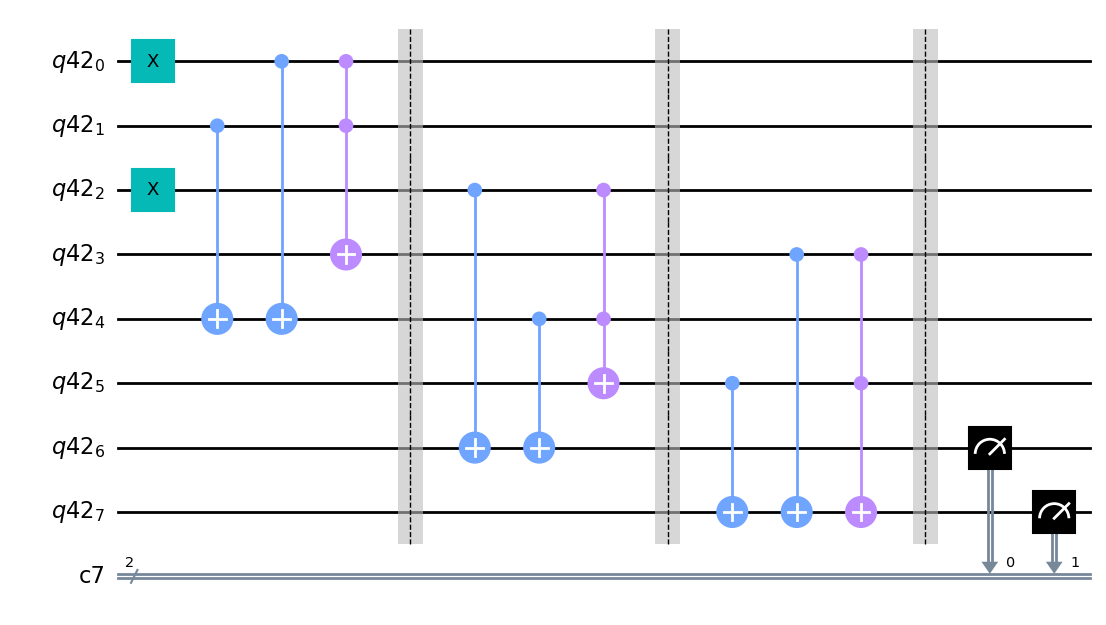

In [39]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute

# 各レジスター、量子回路を宣言
q = QuantumRegister(8)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)

# 入力データを入れます
qc.x(0)
qc.x(2)

# 量子回路を作成
def OR(a,b,c):
  qc.cx(q[b], q[c])
  qc.cx(q[a], q[c])
  qc.ccx(q[a], q[b], q[c])

def hadder(a,b,s,c):
  #XOR
  qc.cx(q[b], q[s])
  qc.cx(q[a], q[s])
  #AND
  qc.ccx(q[a], q[b], q[c])

hadder(0,1,4,3)
qc.barrier(q)
hadder(4,2,6,5)
qc.barrier(q)
OR(3,5,7)
qc.barrier(q)

#観測
qc.measure(q[6], c[0])
qc.measure(q[7], c[1])


# qasm_simulatorを使って回路を実行させてください。
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000) # 1000回のサンプルを取ったときのc[0], c[1]の測定結果
result = job.result()
count = result.get_counts()
print(count)
qc.draw(output='mpl')


入力と出力の量子ビットのブロッホ球表示も確認してみましょう

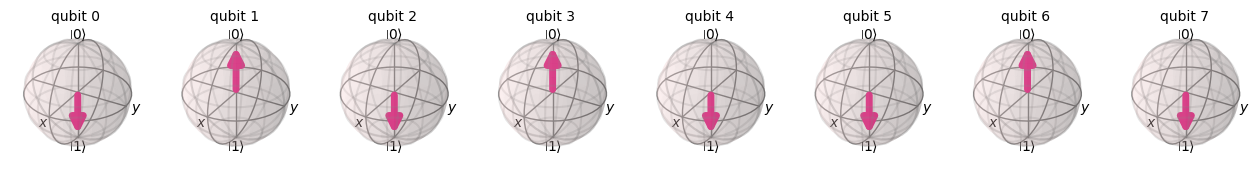

In [44]:
backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result().get_statevector(qc, decimals=3)
plot_bloch_multivector(result)

Unrollerでコストも計算してください

In [46]:
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc) 
new_circuit.draw(output='mpl')
new_circuit.count_ops()

OrderedDict([('u3', 29), ('cx', 24), ('barrier', 3), ('measure', 2)])

Unrollerを用いて計算したこの回路のコストは、29 + 24 × 10 = 279 となります。